In [2]:
# Importing the libraries
import pandas as pd
import pandas_datareader as pdr
from datetime import datetime
import matplotlib.pyplot as plt

In [3]:
class OneStockData:
    def __init__(self, ticker, start = None, end = None):
        self._ticker = ticker.upper()
        if not start:
            start = datetime(1900, 1, 1)
        if not end:
            end = datetime.today()
        
        try:
            # Reading data from pandas datareader
            self.stock_df = pdr.get_data_yahoo(self.ticker, start = start, end = end)
            
            # Writing the data into a CSV, in case API read fails
            self.stock_df.to_csv('Datasets/' + self.ticker + '.csv')
        except:
            self.stock_df = pd.read_csv('Datasets/' + self.ticker + '.csv', index_col = 'Date', parse_dates = True)
        
        # Start and end date of the stock's data
        self._start_date = self.stock_df.index[0]
        self._end_date = self.stock_df.index[-1]
        
    # Using property to get start date
    @property
    def start_date(self):
        return self._start_date
    
    # Using property to get end date
    @property
    def end_date(self):
        return self._end_date
    
    # Using property to get ticker
    @property
    def ticker(self):
        return self._ticker
        
    # Return data in date range
    def getDataInRange(self, start, end = None):
        # Handling start date
        if start < self.start_date:
            start = self.start_date
        
        # Handling end date
        if not end:     
            end = self.end_date
        elif end > self.end_date:
            end = self.end_date
        
        return self.stock_df.copy().loc[start:end]
    
    # Moving Windows
    def movingWindows(self, short_window = 40, long_window  = 100, **kwargs):
        '''
        Parameters
        ----------
        short_window: Fast moving window
        long_window: Slow moving window
        
        **kwargs
        --------
        color: str, list or tuple. Default is ('black', 'skyblue', 'orange')
        grid: bool. Default is False
        start: datetime. Start date of plotting
        end: datetime. End date of plotting
        '''
    
        # Handling kwargs
        accepted_kwargs = ('color', 'grid', 'start', 'end')
        for key in kwargs:
            if key not in accepted_kwargs:
                raise ValueError(f"'{key}' is not allowed!")
        # Color
        if 'color' not in kwargs:
            kwargs['color'] = ('black', 'skyblue', 'orange')
        elif not kwargs['color']:
            kwargs['color'] = ('black', 'skyblue', 'orange')
        # Grid
        if 'grid' not in kwargs:
            kwargs['grid'] = False
        elif type(kwargs['grid']) != bool:
            raise TypeError("'type' of 'grid' must be bool.")
        # Start
        if 'start' not in kwargs:
            kwargs['start'] = self.start_date
        elif type(kwargs['start']) != datetime:
            raise TypeError("'type' of 'start' must be datetime.")
        elif kwargs['start'] < self.start_date:
            kwargs['start'] = self.start_date
        # End
        if 'end' not in kwargs:
            kwargs['end'] = self.end_date
        elif type(kwargs['end']) != datetime:
            raise TypeError("'type' of 'end' must be datetime.")
        elif kwargs['end'] > self.end_date:
            kwargs['end'] = self.end_date
            
        # Ranging DataFrame
        stock_df = self.getDataInRange(start = kwargs['start'], end = kwargs['end']).copy()

        # Short and long moving windows rolling mean
        stock_df[f'{short_window} days'] = stock_df['Adj Close'].rolling(window = short_window).mean()
        stock_df[f'{long_window} days'] = stock_df['Adj Close'].rolling(window = long_window).mean()

        # Plot adjusted close price, short and long windows rolling means
        stock_df[['Adj Close', f'{short_window} days', f'{long_window} days']].plot(figsize = (15, 10),
                                                                                    color = kwargs['color'],
                                                                                    grid = kwargs['grid'])
        # Labelling
        plt.ylabel('Price in $')
        plt.title(f'{self.ticker}')

        plt.show()
    
    # Simple Moving Average - Crossover Strategy
    def SMA_CS(self, short_window = 40, long_window = 100, **kwargs):
        '''
        Parameters
        ----------
        short_window: Fast moving window
        long_window: Slow moving window
        
        **kwargs
        --------
        start: datetime. Start date of plotting
        end: datetime. End date of plotting
        '''
        
        # Ranged Data
        if 'start' not in kwargs:
            kwargs['start'] = self.start_date
        elif kwargs['start'] < self.start_date:
            kwargs['start'] = self.start_date
        if 'end' not in kwargs:
            kwargs['end'] = self.end_date
        elif kwargs['end'] > self.end_date:
            kwargs['end'] = self.end_date
        ranged_df = self.getDataInRange(start = kwargs['start'], end = kwargs['end'])
        
        # Initialize signals DataFrame with Signal column having values 0
        self.signals = pd.DataFrame(data = 0, index = ranged_df.index, columns = ['Signal'])

        # Create short and long moving averages columns
        self.signals[f'Short ({short_window} days)'] = ranged_df['Close'].rolling(window = short_window,
                                                                                  min_periods = 1,
                                                                                  center = False).mean()
        self.signals[f'Long ({long_window} days)'] = ranged_df['Close'].rolling(window = long_window,
                                                                           min_periods = 1,
                                                                           center = False).mean()

        # Create signals
        from numpy import where
        self.signals['Signal'][short_window:] = where(self.signals[f'Short ({short_window} days)'][short_window:] >
                                                 self.signals[f'Long ({long_window} days)'][short_window:], 1, 0)

        # Trading orders
        self.signals['Positions'] = self.signals['Signal'].diff()

        # Plotting short and long moving averages
        self.signals[[f'Short ({short_window} days)',
                 f'Long ({long_window} days)']].plot(figsize = (15, 10),
                                                     color = ['skyblue', 'orange'])
        plt.ylabel('Price in $')

        # Plotting buy signals
        plt.scatter(self.signals[self.signals['Positions'] == 1].index,
                    self.signals[self.signals['Positions'] == 1][f'Short ({short_window} days)'],
                    marker = '^', s = 9 ** 2, color = 'green')

        # Plotting sell signalsself.stock_df
        plt.scatter(self.signals[self.signals['Positions'] == -1].index,
                    self.signals[self.signals['Positions'] == -1][f'Short ({short_window} days)'],
                    marker = 'v', s = 9 ** 2, color = 'red')
        plt.show()
        
    # Backtesting
    # Activate this function only after SMA_CS has been executed
    def backtest(self, initial_capital, shares):
        # Dataframe 'portfolio' to backtest SMA-CS
        self.portfolio = pd.DataFrame(index = self.signals.index)

        # Buy 'shares' on the day when short moving average crosses long moving average
        self.portfolio[self.ticker] = shares * self.signals['Signal']

        # Differences in shares owned
        self.portfolio['Diff'] = self.portfolio[self.ticker].diff()

        # Holdings of the shares
        self.portfolio['Holdings'] = self.portfolio[self.ticker].multiply(self.stock_df['Adj Close'], axis = 0)

        # Cash in hand
        self.portfolio['Cash'] = initial_capital - self.portfolio['Diff'].multiply(self.stock_df['Adj Close']).cumsum()

        # Total at an instant
        self.portfolio['Total'] = self.portfolio['Holdings'] + self.portfolio['Cash']

        # Returns of stocks
        self.portfolio['Returns'] = self.portfolio['Total'].pct_change()

        self.portfolio['Total'].plot(figsize = (15, 10))
        plt.ylabel('Portfolio Value in $')

        # Plotting buy signals
        plt.scatter(self.portfolio[self.signals['Positions'] == 1].index,
                    self.portfolio[self.signals['Positions'] == 1]['Total'],
                    marker = '^', s = 9 ** 2, color = 'green')

        # Plotting sell signals
        plt.scatter(self.portfolio[self.signals['Positions'] == -1].index,
                    self.portfolio[self.signals['Positions'] == -1]['Total'],
                    marker = 'v', s = 9 ** 2, color = 'red')
        plt.show()

In [4]:
obj = OneStockData('GOOG')
obj.stock_df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2004-08-19,51.835709,47.800831,49.813286,49.982655,44871300.0,49.982655
2004-08-20,54.336334,50.062355,50.316402,53.952770,22942800.0,53.952770
2004-08-23,56.528118,54.321388,55.168217,54.495735,18342800.0,54.495735
2004-08-24,55.591629,51.591621,55.412300,52.239193,15319700.0,52.239193
2004-08-25,53.798351,51.746044,52.284027,52.802086,9232100.0,52.802086


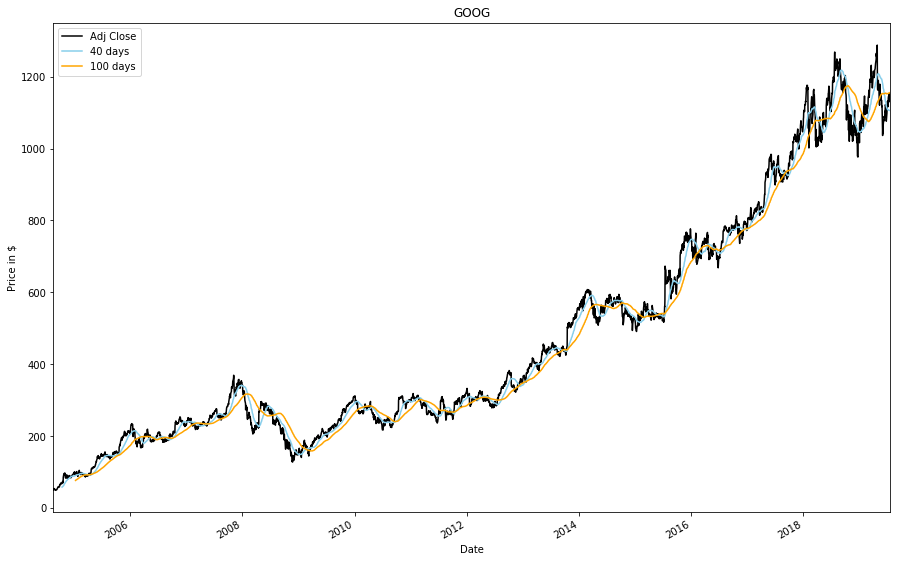

/home/kartik/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


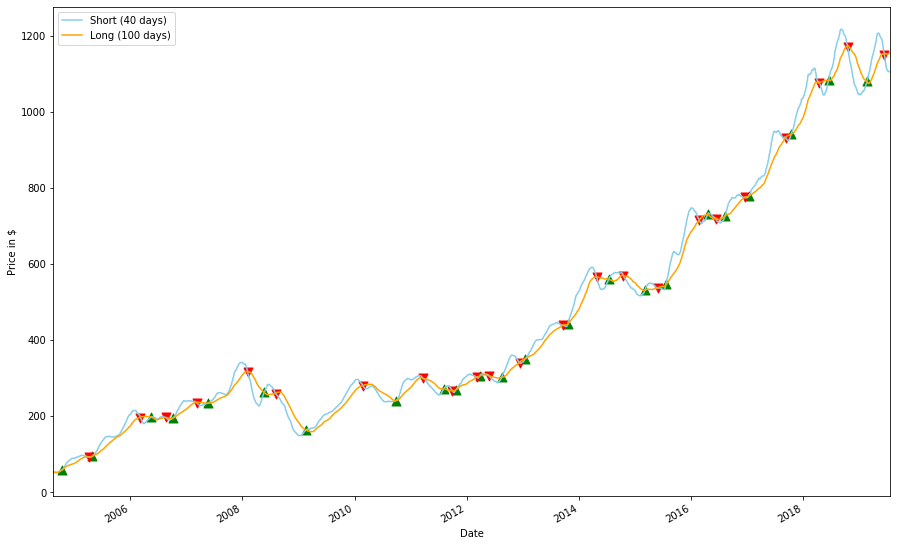

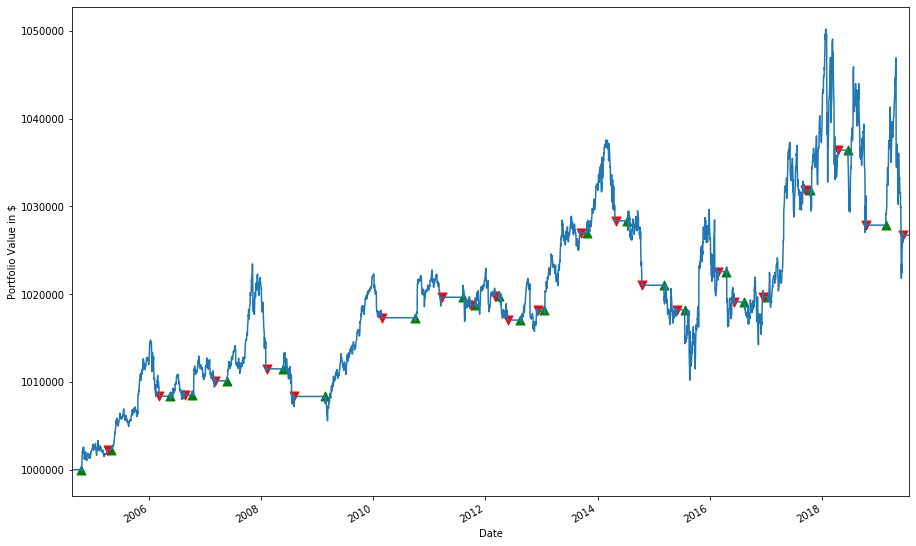

In [5]:
obj.movingWindows()
obj.SMA_CS()
obj.backtest(1000000, 100)